In [1]:
import numpy as np
import xarray
import os
from matplotlib import pyplot as plt
import scipy.signal as scipy_signal
import scipy.stats as scipy_stats
from geopy import distance as geo_dist
import cmocean
import pandas
import proplot
import cartopy.feature as cfeature

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
def isosurface(field, target, dim):
    """
    Linearly interpolate a coordinate isosurface where a field
    equals a target

    Parameters
    ----------
    field : xarray DataArray
        The field in which to interpolate the target isosurface
    target : float
        The target isosurface value
    dim : str
        The field dimension to interpolate
        
    Examples
    --------
    Calculate the depth of an isotherm with a value of 5.5:
    
    >>> temp = xr.DataArray(
    ...     range(10,0,-1),
    ...     coords={"depth": range(10)}
    ... )
    >>> isosurface(temp, 5.5, dim="depth")
    <xarray.DataArray ()>
    array(4.5)
    """
    slice0 = {dim: slice(None, -1)}
    slice1 = {dim: slice(1, None)}

    field0 = field.isel(slice0).drop(dim)
    field1 = field.isel(slice1).drop(dim)

    crossing_mask_decr = (field0 > target) & (field1 <= target)
    crossing_mask_incr = (field0 < target) & (field1 >= target)
    crossing_mask = xarray.where(
        crossing_mask_decr | crossing_mask_incr, 1, np.nan
    )

    coords0 = crossing_mask * field[dim].isel(slice0).drop(dim)
    coords1 = crossing_mask * field[dim].isel(slice1).drop(dim)
    field0 = crossing_mask * field0
    field1 = crossing_mask * field1

    iso = (
        coords0 + (target - field0) * 
        (coords1 - coords0) / (field1 - field0)
    )

    return iso.max(dim, skipna=True)

In [3]:
track_file_path = '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC'
olive_ridley_dir = 'tu117'
flatback_dir     = 'tu120'


olive_ridley_files = os.listdir(os.path.join(track_file_path,olive_ridley_dir))
olive_ridley_files_list = []

for i_file in olive_ridley_files:
    
    if i_file.endswith('_hr0_prof.nc'):
        olive_ridley_files_list.append(os.path.join(track_file_path,olive_ridley_dir,i_file))
        

flatback_files = os.listdir(os.path.join(track_file_path,flatback_dir))
flatback_files_list = []

for i_file in flatback_files:
    
    if i_file.endswith('_hr0_prof.nc'):
        flatback_files_list.append(os.path.join(track_file_path,flatback_dir,i_file))


turtle_files = olive_ridley_files_list + flatback_files_list



#track_data_frame = pandas.read_csv(track_file_name)

In [4]:
turtle_files

['/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-674-22_hr0_prof.nc',
 '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-751-22_hr0_prof.nc',
 '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-688-22_hr0_prof.nc',
 '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-617-22_hr0_prof.nc',
 '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-611-22_hr0_prof.nc',
 '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-689-22_hr0_prof.nc',
 '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-672-22_hr0_prof.nc',
 '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-685-22_hr0_prof.nc',
 '/oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-670-22_hr0_pr

In [9]:
first_pass = True


turtle_dataframe  = {} #{'id':[],'lat':[],'lon':[],'time':[]}


for i_turtle in turtle_files:
    turtle_ds = xarray.open_dataset(i_turtle)
    #print(turtle_ds)
    time = xarray.CFTimeIndex(turtle_ds['JULD'].values).to_datetimeindex()
    
    if first_pass:
        min_time = time.min()
        max_time = time.max()
        
        turtle_dataframe['id'] = turtle_ds['PLATFORM_NUMBER'].values.astype('int')
        turtle_dataframe['lat'] = turtle_ds['LATITUDE'].values
        turtle_dataframe['lon'] = turtle_ds['LONGITUDE'].values
        turtle_dataframe['date'] = time


        
        first_pass = False
    else:
        if time.min()<min_time:
            min_time = time.min()
        if time.max()>max_time:
            max_time = time.max()
            
        turtle_dataframe['id']   = np.concatenate([turtle_dataframe['id'], turtle_ds['PLATFORM_NUMBER'].values.astype('int')])
        turtle_dataframe['lat']  = np.concatenate([turtle_dataframe['lat'], turtle_ds['LATITUDE'].values])
        turtle_dataframe['lon']  = np.concatenate([turtle_dataframe['lon'], turtle_ds['LONGITUDE'].values])
        turtle_dataframe['date'] = np.concatenate([turtle_dataframe['date'], time])


turtle_dataframe = pandas.DataFrame(data=turtle_dataframe)

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # Remove the CWD from sys.path while we load stuff.


In [10]:
era5_slp        = xarray.open_dataset('/oa-decadal-climate/work/observations/Anibos_Turtles/ERA5_Cyclone_Isla/era5_slp_northern_aus_april_2023.nc')
era5_wind_speed = xarray.open_dataset('/oa-decadal-climate/work/observations/Anibos_Turtles/ERA5_Cyclone_Isla/era5_wind_speed_northern_aus_april_2023.nc')

In [7]:
turtle_id_to_plot =  '61922'

#turtle_path = turtle_dataframe.loc[turtle_dataframe['id']==turtle_id_to_plot]

plt.scatter(turtle_dataframe['lon'],turtle_dataframe['lat']) #,c=pandas.to_datetime(turtle_dataframe['time']))

In [23]:
albatross = track_data_frame.loc[track_data_frame['species'] == 'AUSFS']


In [36]:
single_turtle = xarray.open_dataset(os.path.join(track_file_path,flatback_dir,'tu120-619-22_hr1_prof.nc'),decode_times=False)
ref_date = pandas.Timestamp('1950-01-01')
turtle_dates = []
for i_timestamp in single_turtle['JULD'].values:
    turtle_dates.append(pandas.Timedelta(i_timestamp,'d') + ref_date)
    #print(turtle_dates)
single_turtle['date'] = np.asarray(turtle_dates)


In [49]:
single_turtle['date'].values

array(['2022-10-07T17:35:00.000009600', '2022-10-08T05:55:00.000019200',
       '2022-10-08T11:05:00.000038400', ...,
       '2024-01-02T01:00:00.000028800', '2024-01-03T19:20:00.000038399',
       '2024-01-04T01:00:00.000028800'], dtype='datetime64[ns]')

In [83]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
import cartopy
import cartopy.crs as ccrs
from shapely.geometry.polygon import LinearRing


unique_ids = turtle_dataframe['id'].unique()






proplot.rc['land.color'] = 'grey'
proplot.rc['text.labelsize'] = 15
proplot.rc['text.titlesize'] = 25
proplot.rc['abc.size'] = 15
proplot.rc['abc.style'] = 'a'
proplot.rc.reso = 'hi'

#SW Tas Domain
lon_min = 120
lon_max = 132
lat_min = -20
lat_max = -5

start_date = pandas.Timestamp('2023-04-08')
end_date   = pandas.Timestamp('2023-04-10')


proj = proplot.Proj('cyl', basemap=False)


image_layout = [[1,1,1],
                [1,1,1],
                [1,1,1]]

plt.figure(1,figsize=(20,10))
fig, axs = proplot.subplots(image_layout,axwidth='30cm',aspect=2.5,proj={1:proj} ) #,2:None,3:None,4:None})
axs.format(abc=False,share=0,land=True) #, color='grey')


for i_animal in unique_ids:
#for i_animal in  [99354]:
    animal_to_follow = turtle_dataframe.loc[turtle_dataframe['id'] == i_animal ]
    mask             = (animal_to_follow['date'] > start_date) & (animal_to_follow['date'] <= end_date)
    #print(mask)
    #dsa
    if any(mask):
    
        animal_to_follow = animal_to_follow.loc[mask] #and animal_to_follow[time]>end_date]
    
        lat_animal = animal_to_follow['lat']
        lon_animal = animal_to_follow['lon']
        time_animal = pandas.to_datetime(animal_to_follow['date'].values)
        axs[0].scatter(lon_animal,lat_animal,label=str(i_animal),cycle='tab20',s=100)




era5_slp_on_date = era5_slp.sel(time='2023-04-9',method='nearest')


clines = axs[0].contour(era5_slp_on_date['longitude'],era5_slp_on_date['latitude'],era5_slp_on_date['msl'][20,:,:]*0.01,levels=np.arange(995,1015.1,1),colors='black')
#fig.colorbar(clines)
axs[0].clabel(clines, inline=False, fontsize=15)
era5_slp_min = era5_slp_on_date.where(era5_slp_on_date==era5_slp_on_date.min(), drop=True).squeeze()


axs[0].format(land=False,coast=True,facecolor='white',
                            lonlim=(lon_min, lon_max), latlim=(lat_min, lat_max), 
                            labels=True,lonlines=np.arange(0,360,2.5),latlines=np.arange(-80,50,2))
#axs[0].legend(loc='lr',ncol=1)
dates_to_get = ['2023-04-08','2023-04-10','2023-04-12']

#ix = axs[0].inset(
#    [0.6, -0.10, 0.4, 0.5], transform='figure', zoom=False,proj=None)
ix = fig.add_axes([0.75, 0.07, 0.2, 0.3])


for i_date in dates_to_get:
    
    idx_date = np.nonzero(single_turtle['date'].values>np.datetime64(i_date))[0][0]
    profile = single_turtle.isel(N_PROF=idx_date)
    
    ix.plot(profile['TEMP_ADJUSTED'],-profile['PRES_ADJUSTED'],label=i_date,linewidth=3.0)
ix.legend(loc='lower right',ncol=1)
ix.set_ylim([-100,0])
ix.set_xlim([27,31])
ix.set_xticks([27,28,29,30,31])
ix.set_yticks(np.arange(-100,1,25))
ix.set_yticklabels(np.arange(100,-1,-25))
ix.set_ylabel('Depth (m)',fontsize=20)
ix.set_xlabel('Temperature ($^{\circ}$C)',fontsize=20)





    

output_path = './Figures'
figure_file_name = 'Cyclone_Turtle_Map_with_Profile_Inset'
fig.savefig(os.path.join(output_path,figure_file_name + '.png'),dpi=400)
fig.savefig(os.path.join(output_path,figure_file_name + '.pdf'),dpi=100)


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/config.py:555: ProPlotWarning: rc setting 'share' was renamed to subplots.share in version 0.6.


<Figure size 2000x1000 with 0 Axes>

In [51]:
profile

<xarray.Dataset>
Dimensions:                       (N_PARAM: 3, N_LEVELS: 1000, N_CALIB: 1, date: 1190)
Coordinates:
  * date                          (date) datetime64[ns] 2022-10-07T17:35:00.0...
Dimensions without coordinates: N_PARAM, N_LEVELS, N_CALIB
Data variables: (12/46)
    DATA_TYPE                     object b'Argo profile    '
    FORMAT_VERSION                object b'3.0 '
    HANDBOOK_VERSION              object b'3.0 '
    REFERENCE_DATE_TIME           object b'19500101000000'
    DATE_CREATION                 object b'20240307103515'
    DATE_UPDATE                   object b'20240307103515'
    ...                            ...
    PSAL_ADJUSTED                 (N_LEVELS) float32 ...
    PSAL_ADJUSTED_QC              (N_LEVELS) object ...
    PSAL_ADJUSTED_ERROR           (N_LEVELS) float32 ...
    PARAMETER                     (N_CALIB, N_PARAM) object b'PRES           ...
    SCIENTIFIC_CALIB_EQUATION     (N_CALIB, N_PARAM) object b'Pc = P - ( p1 [...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_CALIB, N_PARAM) object b'p1= 0.000000e+0...
Attributes: (12/46)
    comment:                   
    number_of_ts_profiles:    16.0
    number_of_t_profiles:     1182.0
    number_chla_profiles:     0.0
    number_doxy_profiles:     0.0
    number_light_profiles:    0.0
    ...                       ...
    location:                 North Australia
    loc_algorithm:            K
    firmware_version:         228
    firmware_parameters:      AUST_CTD_GPS_22A
    instr_id:                 15619
    ptt:                      223891

In [ ]:


proplot.rc['land.color'] = 'grey'
proplot.rc['text.labelsize'] = 15
proplot.rc['text.titlesize'] = 25
proplot.rc['abc.size'] = 15
proplot.rc['abc.style'] = 'a'
proplot.rc.reso = 'hi'

#Northern Australia Domain
lon_min = 120
lon_max = 150
lat_min = -20
lat_max = 0




proj = proplot.Proj('cyl', basemap=False)


turtle_date = pandas.to_datetime(turtle_dataframe['date'].values)

animal_colors = proplot.Colors('tab20')

start_date = turtle_date.min()
end_date   = turtle_date.max()


date_range = pandas.date_range(start_date,end_date,freq='1H')

unique_ids = turtle_dataframe['id'].unique()



image_counter = 0
for i_time in range(0,date_range.size-1):
    #(df['column_name'] >= A) & (df['column_name'] <= B)
    #print(sst_time_albatros[i_time])
    #dsa
    tracks_for_date = turtle_dataframe.loc[(turtle_date>date_range[i_time]-np.timedelta64(10,'D')) & (turtle_date<date_range[i_time+1]) ]
    
    
    
    plt.figure(1,figsize=(20,10))
    fig, axs = proplot.subplots(nrows=1, ncols=1,axwidth='30cm',aspect=2.5,proj=proj)
    axs.format(abc=False,share=0) #, color='grey')
    #cs_sst = axs.contourf(sst_dataset['lon'],sst_dataset['lat'],sst_for_albatros['sst'][i_time,:,:],levels=np.linspace(10,22,25),cmap='thermal')
    
    for i_animal in range(0,len(unique_ids)):
        
        animal_to_follow = tracks_for_date.loc[turtle_dataframe['id'] == unique_ids[i_animal]]
        lat_animal  = animal_to_follow['lat'].values
        lon_animal  = animal_to_follow['lon'].values
        time_animal = pandas.to_datetime(animal_to_follow['date'].values)
    
        if len(lat_animal) != 0:
            axs[0].plot(lon_animal,lat_animal,color=animal_colors[i_animal],linestyle='--' )
            axs[0].scatter(lon_animal[-1],lat_animal[-1],c=np.asarray([animal_colors[i_animal]]),markersize=70 )

    
    #END for i_animal
    axs[0].format(land=True,coast=True,facecolor='white',
                            lonlim=(lon_min, lon_max), latlim=(lat_min, lat_max), 
                            labels=True,lonlines=np.arange(0,360,10),latlines=np.arange(-80,50,5))

    
    date_plot_string = date_range[i_time].strftime("%d %B %Y:%H")
    print(date_plot_string)
    #axs[0].colorbar(cs_sst,loc='r',ticks=np.arange(10,22.1,5))
    axs[0].annotate(date_plot_string, xy=(0.05, 1.01), xycoords="axes fraction",fontsize=20)
    
    
    output_path = './Turtle_animation'
    figure_file_name = 'Turtle_frame_' +  str(image_counter).zfill(5)
    
    
    
    plt.savefig(os.path.join(output_path,figure_file_name + '.png'),dpi=100)
    image_counter = image_counter+1
    
    plt.clf()
    
    

In [10]:
single_turtle.close()

In [15]:
#single_turtle['date'] = pandas.to_datetime(xarray.CFTimeIndex(single_turtle['JULD'].values).to_datetimeindex())
#date = xarray.CFTimeIndex(single_turtle['JULD'].values).to_datetimeindex()

In [68]:
single_turtle

<xarray.Dataset>
Dimensions:                       (N_PROF: 1190, N_PARAM: 3, N_LEVELS: 1000, N_CALIB: 1)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB
Data variables: (12/46)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    PSAL_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    PSAL_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    PSAL_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object ...
Attributes: (12/46)
    comment:                   
    number_of_ts_profiles:    16.0
    number_of_t_profiles:     1182.0
    number_chla_profiles:     0.0
    number_doxy_profiles:     0.0
    number_light_profiles:    0.0
    ...                       ...
    location:                 North Australia
    loc_algorithm:            K
    firmware_version:         228
    firmware_parameters:      AUST_CTD_GPS_22A
    instr_id:                 15619
    ptt:                      223891

In [16]:
ref_date = pandas.Timestamp('1950-01-01')
turtle_dates = []
for i_timestamp in single_turtle['JULD'].values:
    turtle_dates.append(pandas.Timedelta(i_timestamp,'d') + ref_date)
    #print(turtle_dates)
single_turtle['date'] = np.asarray(turtle_dates)

In [70]:
single_turtle['date']

<xarray.DataArray 'date' (date: 1190)>
array(['2022-10-07T17:35:00.000009600', '2022-10-08T05:55:00.000019200',
       '2022-10-08T11:05:00.000038400', ..., '2024-01-02T01:00:00.000028800',
       '2024-01-03T19:20:00.000038399', '2024-01-04T01:00:00.000028800'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2022-10-07T17:35:00.000009600 ... 2024-01-...

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/config.py:555: ProPlotWarning: rc setting 'share' was renamed to subplots.share in version 0.6.


<Figure size 2000x1000 with 0 Axes>

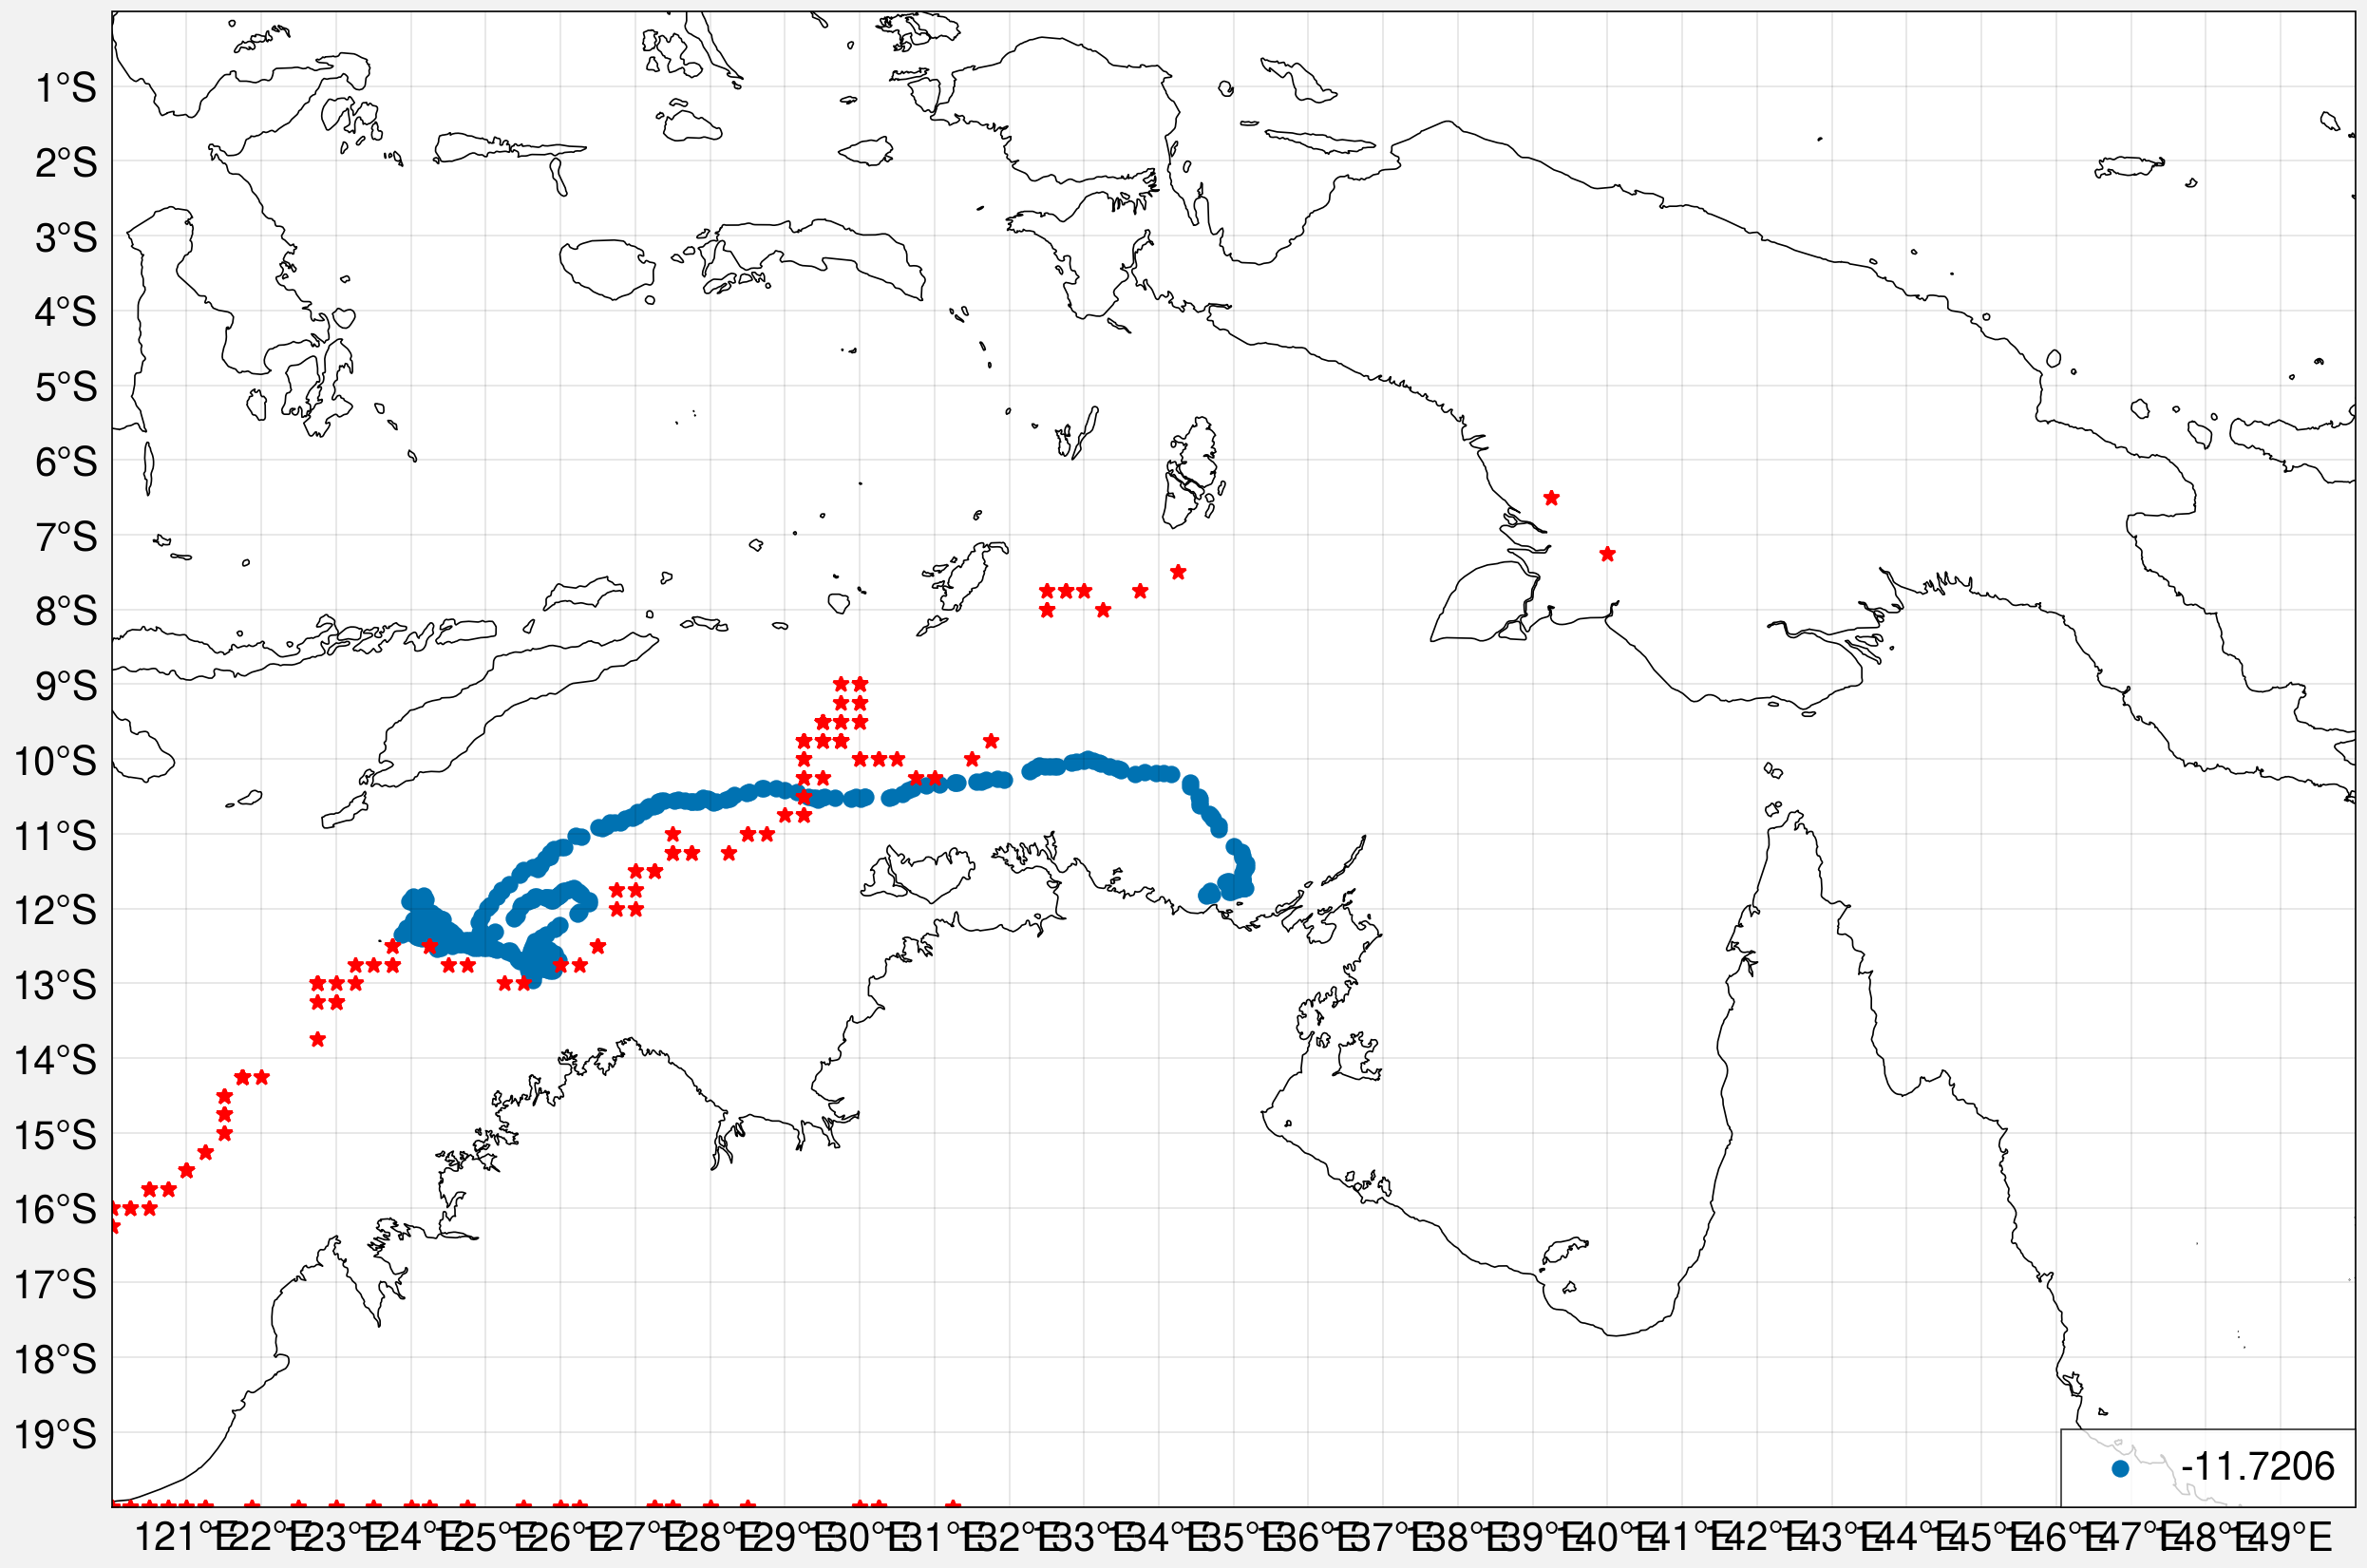

In [18]:
proplot.rc['land.color'] = 'grey'
proplot.rc['text.labelsize'] = 15
proplot.rc['text.titlesize'] = 25
proplot.rc['abc.size'] = 15
proplot.rc['abc.style'] = 'a'
proplot.rc.reso = 'hi'

#SW Tas Domain
lon_min = 120
lon_max = 150
lat_min = -20
lat_max = 0

start_date = pandas.Timestamp('2023-04-06')
end_date   = pandas.Timestamp('2023-04-15')


proj = proplot.Proj('cyl', basemap=False)


plt.figure(1,figsize=(20,10))
fig, axs = proplot.subplots(nrows=1, ncols=1,axwidth='30cm',aspect=2.5,proj=proj)
axs.format(abc=False,share=0) #, color='grey')



axs[0].scatter(single_turtle['LONGITUDE'],single_turtle['LATITUDE'])
axs[0].format(land=False,coast=True,facecolor='white',
                            lonlim=(lon_min, lon_max), latlim=(lat_min, lat_max), 
                            labels=True,lonlines=np.arange(0,360,1),latlines=np.arange(-80,50,1))
axs[0].legend(loc='lr',ncol=1)


dates_to_plot = pandas.date_range(start_date,end_date,freq='H')
#era5_slp_on_date = era5_slp.sel(time=dates_to_plot[4*24],method='nearest')


#axs[0].contour(era5_slp_on_date['longitude'],era5_slp_on_date['latitude'],era5_slp_on_date['msl'],levels=20,colors='black')
#era5_slp_min = era5_slp_on_date.where(era5_slp_on_date==era5_slp_on_date.min(), drop=True).squeeze()
    
#axs[0].plot(era5_slp_min['longitude'].values,era5_slp_min['latitude'].values,'r*')
#dsa

for i_date in dates_to_plot:
    era5_slp_on_date = era5_slp.sel(time=i_date)
    
    era5_slp_min = era5_slp_on_date.where(era5_slp_on_date==era5_slp_on_date.min(), drop=True).squeeze()
    
    axs[0].plot(era5_slp_min['longitude'].mean().values,era5_slp_min['latitude'].mean().values,'r*')



In [108]:
dates_to_plot.size/

DatetimeIndex(['2023-04-06 00:00:00', '2023-04-06 01:00:00',
               '2023-04-06 02:00:00', '2023-04-06 03:00:00',
               '2023-04-06 04:00:00', '2023-04-06 05:00:00',
               '2023-04-06 06:00:00', '2023-04-06 07:00:00',
               '2023-04-06 08:00:00', '2023-04-06 09:00:00',
               ...
               '2023-04-14 15:00:00', '2023-04-14 16:00:00',
               '2023-04-14 17:00:00', '2023-04-14 18:00:00',
               '2023-04-14 19:00:00', '2023-04-14 20:00:00',
               '2023-04-14 21:00:00', '2023-04-14 22:00:00',
               '2023-04-14 23:00:00', '2023-04-15 00:00:00'],
              dtype='datetime64[ns]', length=217, freq='H')

In [99]:
era5_slp_on_date

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 81)
Coordinates:
  * longitude  (longitude) float32 100.0 100.2 100.5 100.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 0.0 -0.25 -0.5 -0.75 ... -19.5 -19.75 -20.0
    time       datetime64[ns] 2023-04-15
Data variables:
    msl        (latitude, longitude) float32 1.012e+05 1.013e+05 ... 1.008e+05
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-01 19:42:57 UTC+1000 by era5_replication_tools-1.12...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis mean_sea_level_pressure 20230...

In [89]:
era5_slp_min['longitude'].values,era5_slp_min['latitude'].values

(array([], dtype=float32), array([], dtype=float32))

In [94]:
dates_to_plot

DatetimeIndex(['2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09',
               '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
               '2023-04-14', '2023-04-15'],
              dtype='datetime64[ns]', freq='D')

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    longitude  float32 121.8
    latitude   float32 -14.25
    time       datetime64[ns] 2023-04-10T20:00:00
Data variables:
    msl        float32 9.963e+04
Attributes:
    Conventions:  CF-1.6
    history:      2023-08-01 19:42:57 UTC+1000 by era5_replication_tools-1.12...
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis mean_sea_level_pressure 20230...

In [19]:
turtle_lon = xarray.DataArray(single_turtle['LONGITUDE'].values, dims="z")
turtle_lat = xarray.DataArray(single_turtle['LATITUDE'].values, dims="z")
turtle_time = xarray.DataArray(single_turtle['date'].values, dims="z")

slp_single_turtle = era5_slp['msl'].interp(longitude=turtle_lon, latitude=turtle_lat,time=turtle_time).compute() 
wind_single_turtle = era5_wind_speed['wind'].interp(longitude=turtle_lon, latitude=turtle_lat,time=turtle_time).compute() 

#.sel(time=single_turtle['date'],method='nearest')
single_turtle['msl'] = xarray.DataArray(slp_single_turtle.squeeze().values,dims=['N_PROF'],coords={'N_PROF':single_turtle['N_PROF']})
single_turtle['wind_speed'] = xarray.DataArray(wind_single_turtle.squeeze().values,dims=['N_PROF'],coords={'N_PROF':single_turtle['N_PROF']})

In [112]:
single_turtle['PRES_ADJUSTED'][20,:]

<xarray.DataArray 'PRES_ADJUSTED' (N_LEVELS: 1000)>
array([   1.,    2.,    3., ...,  998.,  999., 1000.], dtype=float32)
Coordinates:
    N_PROF   int64 20
Dimensions without coordinates: N_LEVELS
Attributes:
    long_name:  SEA PRESSURE
    units:      decibar
    valid_min:  0.0
    valid_max:  12000.0
    comment:    In situ measurement, sea surface = 0

In [ ]:
TEOS_10.

In [20]:
import gsw as TEOS_10

mlp = np.zeros(single_turtle['N_PROF'].size,dtype='float32')
N_squared = np.zeros([single_turtle['N_PROF'].size,single_turtle['N_LEVELS'].size-1],dtype='float32')

reference_salinity = 35.16504

for i_profile in range(0,single_turtle['N_PROF'].size):
    
    pressure_profile = single_turtle['PRES_ADJUSTED'][0,:]
    temperature_profile  = single_turtle['TEMP_ADJUSTED'][i_profile,:]
    psuedo_salinity_profile = reference_salinity * np.ones(temperature_profile.size)
    latitude = single_turtle['LATITUDE'][i_profile]
    
    CT_profile = TEOS_10.CT_from_t(psuedo_salinity_profile,temperature_profile,pressure_profile)
    #mlp_profile = TEOS_10.mlp(psuedo_salinity_profile,CT_profile,pressure_profile)
    
    N_squared_profile,p_mid = TEOS_10.Nsquared(psuedo_salinity_profile,CT_profile,pressure_profile,latitude)
    N_squared[i_profile,:] = N_squared_profile

    max_temperature = np.nanmax(temperature_profile)
    
    if not(np.isnan(max_temperature)): 
        diff_temperature = (max_temperature - 0.5) - temperature_profile;
        
        idx_mlp = np.nonzero(diff_temperature.values>=0)[0]
        if len(idx_mlp)>0:
         
            mlp[i_profile] = pressure_profile[idx_mlp[0]]
        else:
            mlp[i_profile] = np.nan
        
    else:
        mlp[i_profile] = np.nan
    
N_squared = xarray.DataArray(N_squared,dims=['N_PROF','N_LEVELS_MID'],coords={'N_PROF':single_turtle['N_PROF'],'N_LEVELS_MID':p_mid}) 
single_turtle['N_squared'] = N_squared

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN axis encountered


In [21]:
dates_to_get = ['2023-04-08','2023-04-10','2023-04-12','2023-04-14']

index_for_dates = []
for i_date in dates_to_get:
    idx = np.nonzero(pandas.to_datetime(single_turtle['date'].values)>=i_date)[0][0]
    index_for_dates.append(idx)
    
temperature_on_dates = single_turtle.isel(N_PROF=index_for_dates)

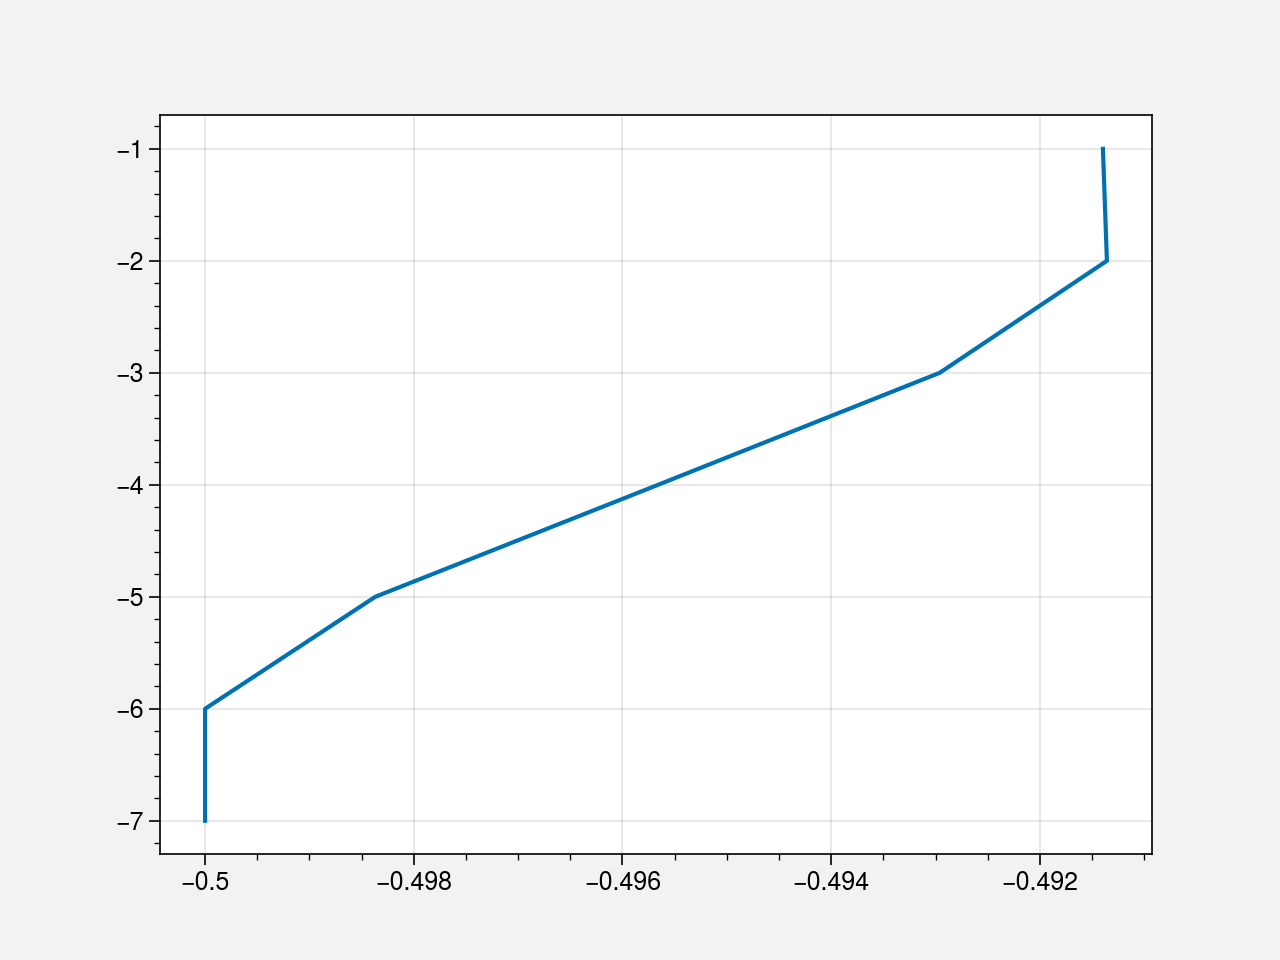

In [181]:
plt.plot(diff_temperature,-pressure_profile)

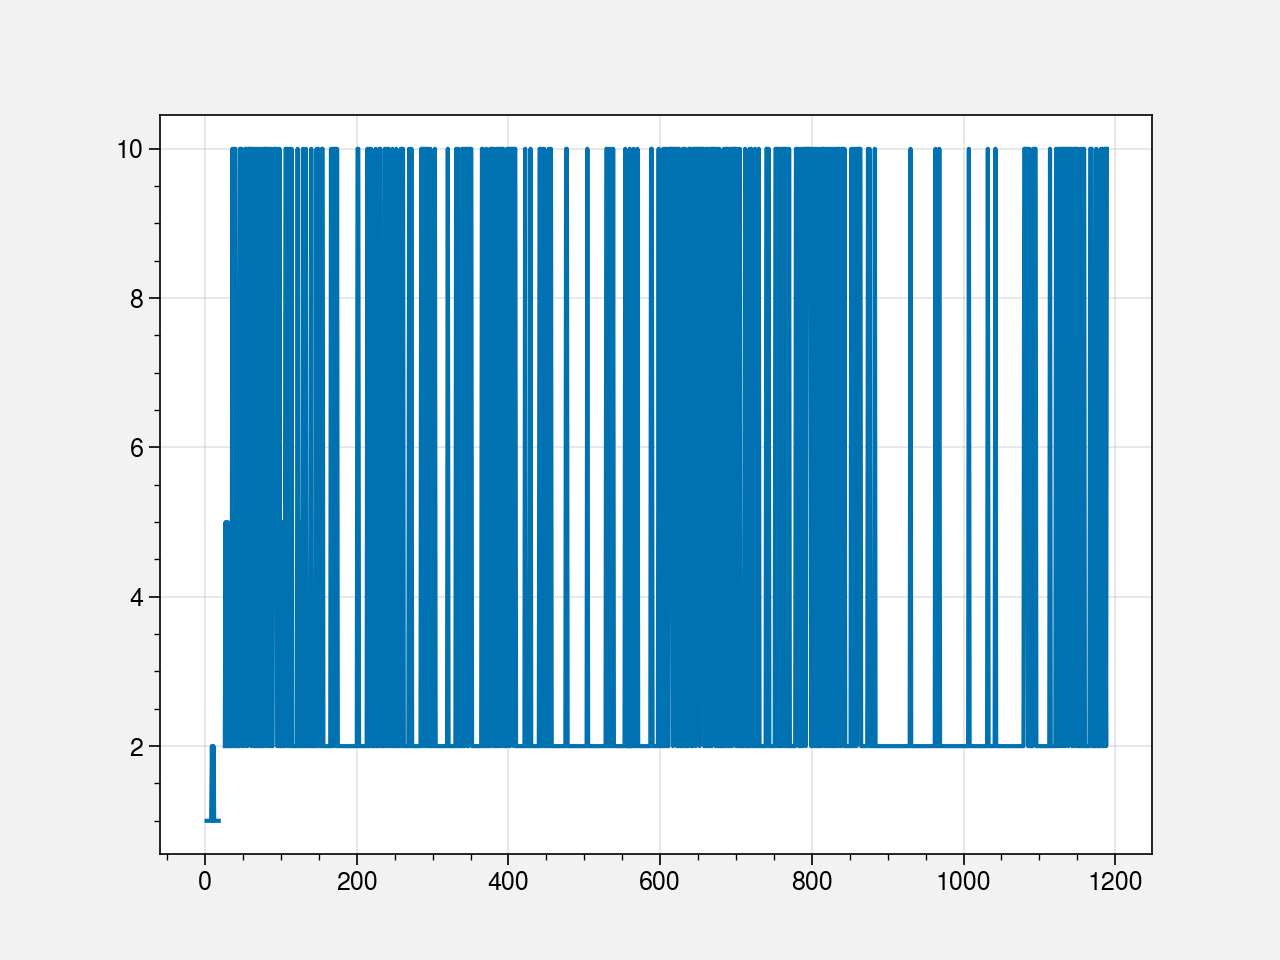

In [170]:
plt.plot(mlp)

In [210]:
temperature_on_dates

<xarray.Dataset>
Dimensions:                       (N_PROF: 4, N_PARAM: 3, N_LEVELS: 1000, N_CALIB: 1, date: 1190, N_LEVELS_MID: 999)
Coordinates:
  * N_PROF                        (N_PROF) int64 524 529 533 541
  * date                          (date) datetime64[ns] 2022-10-07T17:35:00.0...
  * N_LEVELS_MID                  (N_LEVELS_MID) float64 1.5 2.5 ... 998.5 999.5
Dimensions without coordinates: N_PARAM, N_LEVELS, N_CALIB
Data variables: (12/49)
    DATA_TYPE                     object b'Argo profile    '
    FORMAT_VERSION                object b'3.0 '
    HANDBOOK_VERSION              object b'3.0 '
    REFERENCE_DATE_TIME           object b'19500101000000'
    DATE_CREATION                 object b'20240307103515'
    DATE_UPDATE                   object b'20240307103515'
    ...                            ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object b'PRES   ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object b'Pc = P ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object b'p1= 0.0...
    msl                           (N_PROF) float64 1.01e+05 ... 1.01e+05
    wind_speed                    (N_PROF) float64 6.292 8.631 6.559 3.443
    N_squared                     (N_PROF, N_LEVELS_MID) float32 nan ... nan
Attributes: (12/46)
    comment:                   
    number_of_ts_profiles:    16.0
    number_of_t_profiles:     1182.0
    number_chla_profiles:     0.0
    number_doxy_profiles:     0.0
    number_light_profiles:    0.0
    ...                       ...
    location:                 North Australia
    loc_algorithm:            K
    firmware_version:         228
    firmware_parameters:      AUST_CTD_GPS_22A
    instr_id:                 15619
    ptt:                      223891

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/config.py:555: ProPlotWarning: rc setting 'share' was renamed to subplots.share in version 0.6.
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/config.py:555: ProPlotWarning: rc setting 'share' was renamed to subplots.share in version 0.6.
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/config.py:555: ProPlotWarning: rc setting 'share' was renamed to subplots.share in version 0.6.


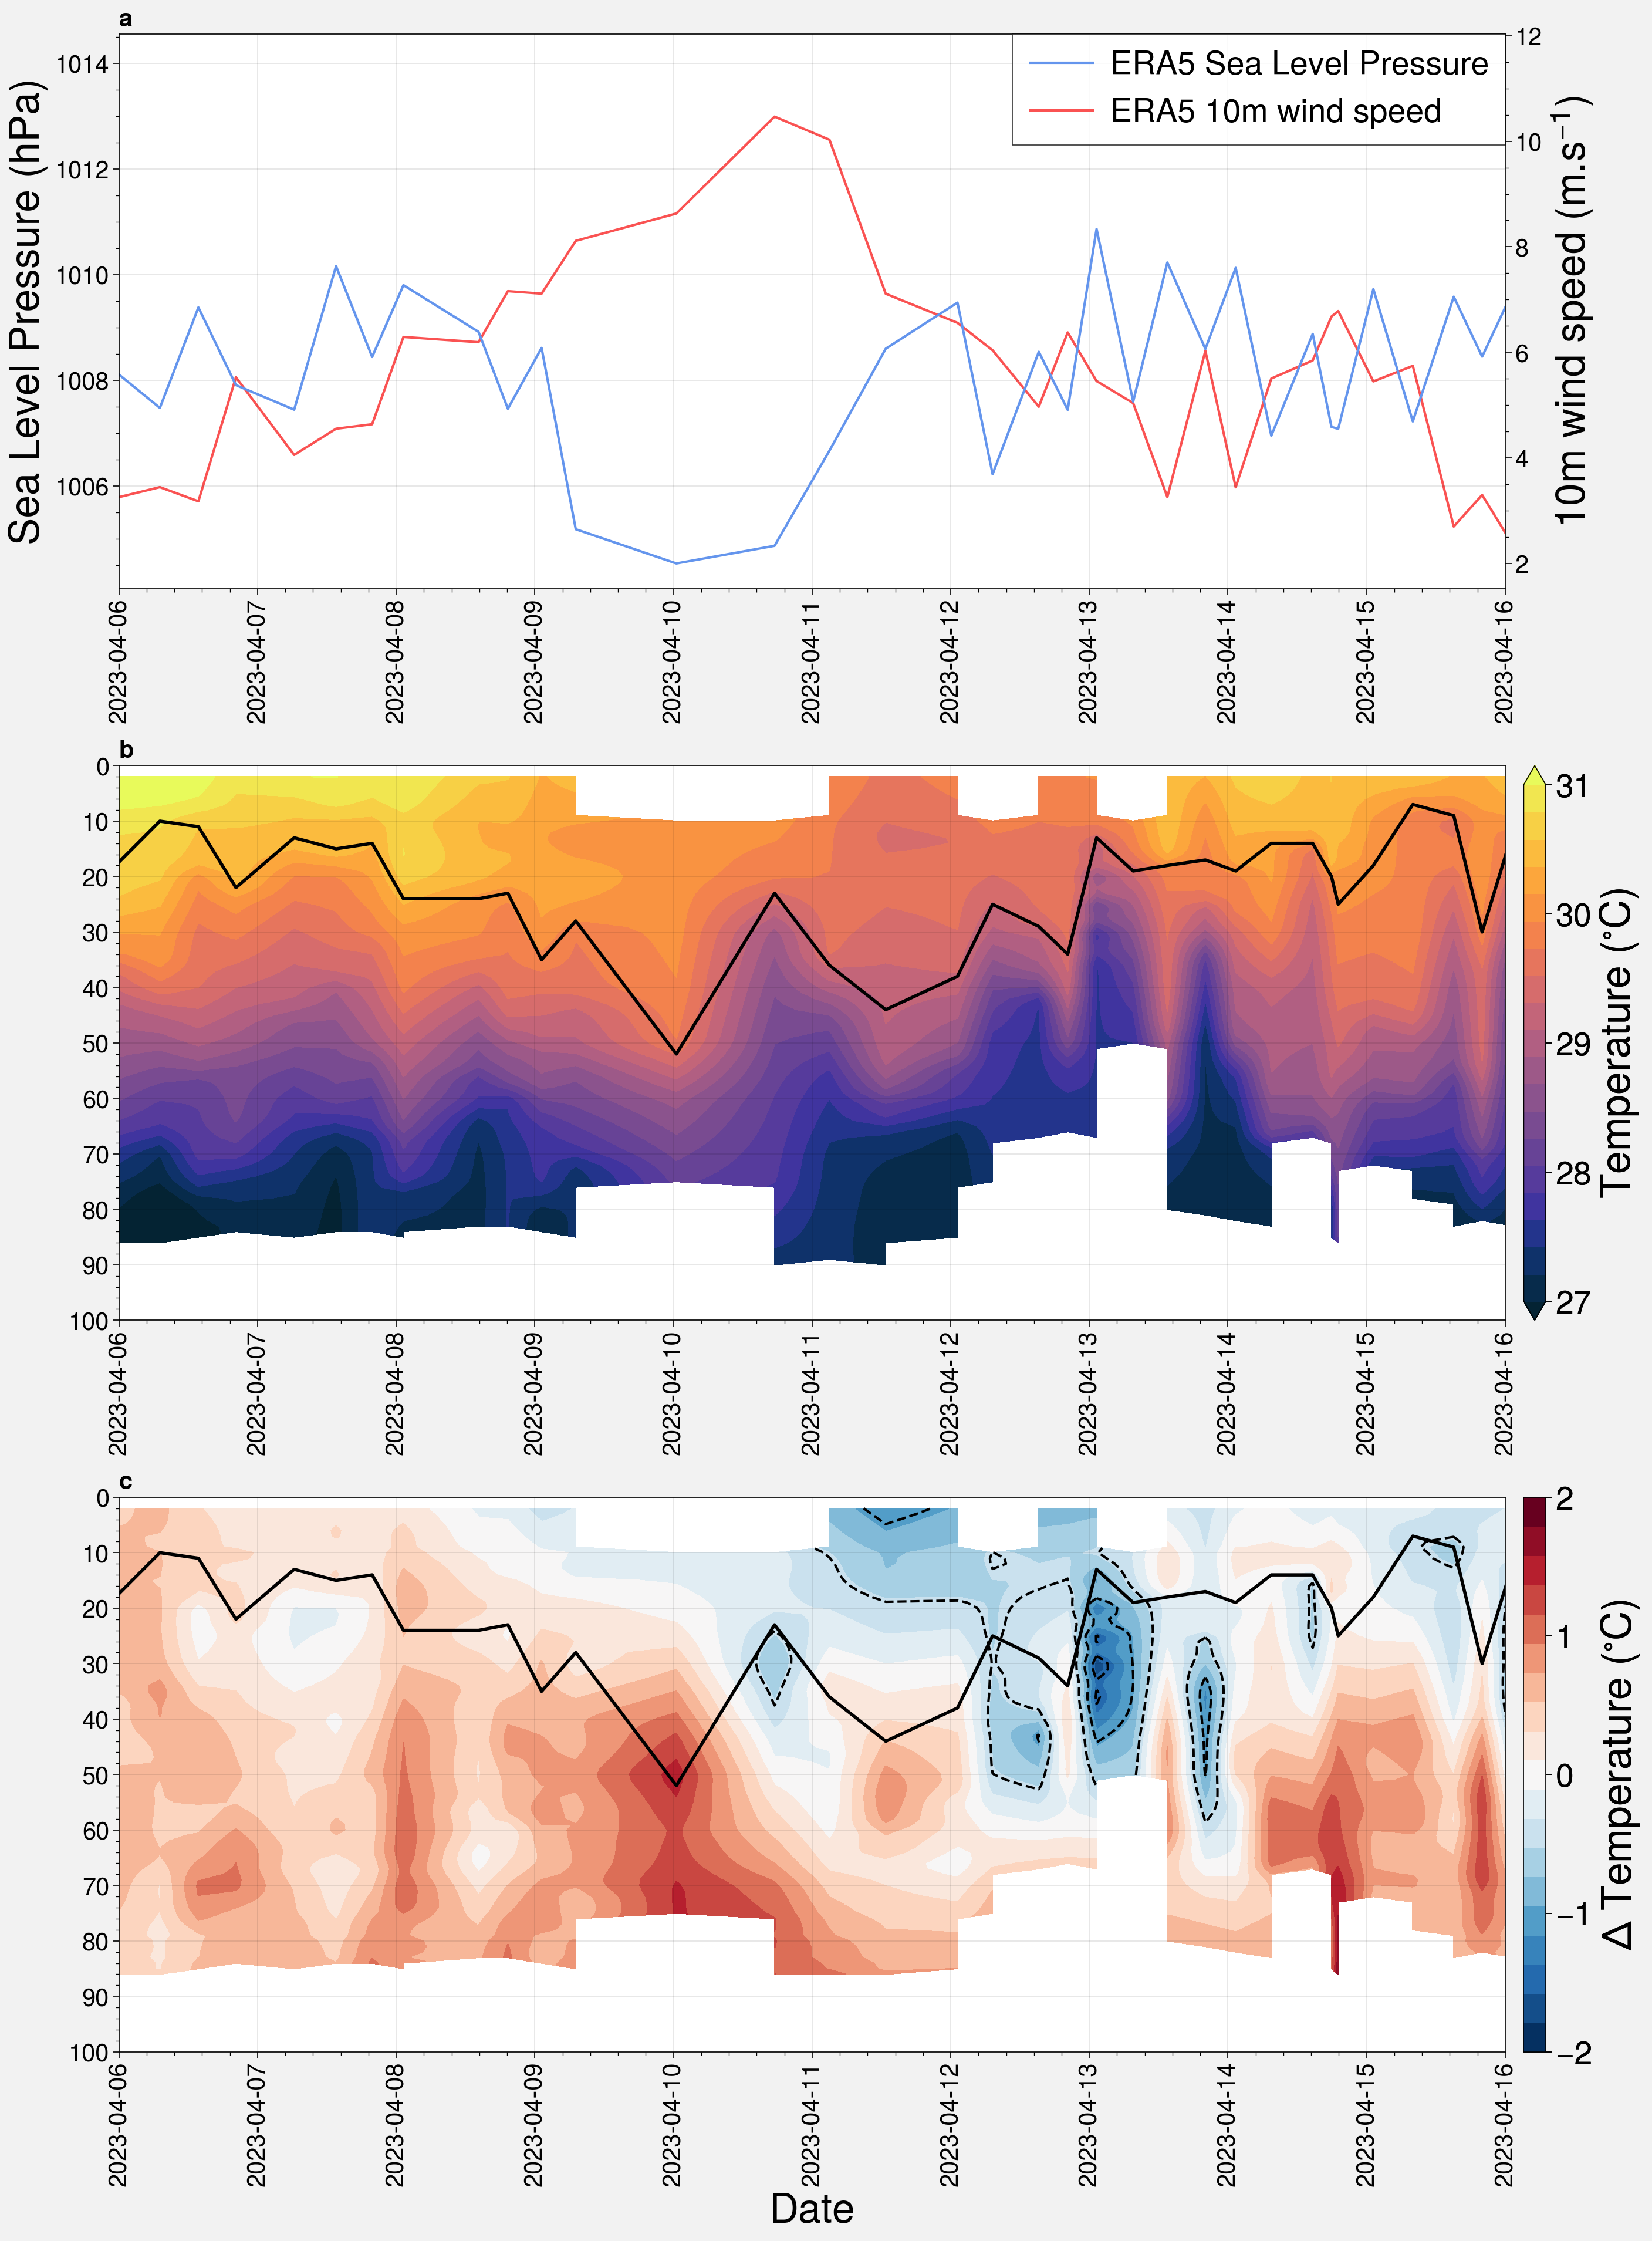

In [27]:

pre_storm_avg_dates = ['2023-04-01','2023-04-05']

start_index = np.nonzero(pandas.to_datetime(single_turtle['date'].values)>pre_storm_avg_dates[0])[0][0]
end_index   = np.nonzero(pandas.to_datetime(single_turtle['date'].values)>pre_storm_avg_dates[1])[0][0]


pres_storm_avg_temperature = single_turtle['TEMP_ADJUSTED'][start_index:end_index,:].mean(dim='N_PROF')


start_date = pandas.Timestamp('2023-04-06')
end_date   = pandas.Timestamp('2023-04-16')


fig, axs = proplot.subplots(nrows=3, ncols=1,axwidth='30cm',aspect=2.5,sharey=False,sharex=True)
axs.format(abc=True,share=4) #, color='grey')


ln1 = axs[0].plot(single_turtle['date'].values,0.01*single_turtle['msl'].values,color='cornflowerblue',label='ERA5 Sea Level Pressure') #,markerstyle='*')
axs[0].set_ylabel('Sea Level Pressure (hPa)',fontsize=25)

ax2 = axs[0].twinx()

ln2 = ax2.plot(single_turtle['date'].values,single_turtle['wind_speed'].values,color='red6',label='ERA5 10m wind speed')

ax2.set_ylabel('10m wind speed (m.s$^{-1}$)',fontsize=25)

lns = ln1+ln2
labs = [l.get_label() for l in lns]plt
axs[0].legend(lns, labs, loc=0,ncol=1,fontsize=20)
axs[0].set_xlim(start_date,end_date)


cs = axs[1].contourf(pandas.to_datetime(single_turtle['date'].values),-single_turtle['PRES_ADJUSTED'][0,:].values,
                       single_turtle['TEMP_ADJUSTED'].T.values,levels=np.linspace(27,31,20),cmap='Thermal',extend='both')
axs[1].contour(pandas.to_datetime(single_turtle['date'].values),-single_turtle['PRES_ADJUSTED'][0,:].values,
                       single_turtle['TEMP_ADJUSTED'].T.values,levels=[26],colors='red')

axs[1].plot(pandas.to_datetime(single_turtle['date'].values),-mlp,color='black',linewidth=2.0)

axs[1].set_ylim(-100,0)
axs[1].set_yticks(np.arange(-100,1,10))
axs[1].set_yticklabels(np.arange(100,-1,-10))

axs[1].set_xlim(start_date,end_date)

colorbar_object = axs[1].colorbar(cs,ticks=np.arange(26,31.1,1),label=r'Temperature ($^{\circ}C$)',labelsize=25,ticklabelsize=20) #,size=25)

cs = axs[2].contourf(pandas.to_datetime(single_turtle['date'].values),-single_turtle['PRES_ADJUSTED'][0,:].values,
                       (single_turtle['TEMP_ADJUSTED'] - pres_storm_avg_temperature).T.values,
                     levels=np.linspace(-2,2,20),cmap='RdBu_r')
axs[2].contour(pandas.to_datetime(single_turtle['date'].values),-single_turtle['PRES_ADJUSTED'][0,:].values,
                       (single_turtle['TEMP_ADJUSTED'] - pres_storm_avg_temperature).T.values,
                     levels=[-2.0,-1.5,-1.0,-0.5],color='black')


axs[2].plot(pandas.to_datetime(single_turtle['date'].values),-mlp,color='black',linewidth=2.0)

axs[2].set_ylim(-100,0)
axs[2].set_yticks(np.arange(-100,1,10))
axs[2].set_yticklabels(np.arange(100,-1,-10))
axs[2].set_xlim(start_date,end_date)

axs[2].colorbar(cs,ticks=np.arange(-2,2.1,1),label=r'$\Delta$ Temperature ($^{\circ}C$)',labelsize=25,ticklabelsize=20)
axs[2].set_xlabel('Date',fontsize=25)

axs[1].axvline(pandas.Timestamp(pre_storm_avg_dates[0]),linestyle='--')
axs[1].axvline(pandas.Timestamp(pre_storm_avg_dates[1]),linestyle='--')


output_path = './Figures'
figure_file_name = 'Temperature_Change_Turtle_Section_with_ERA5'
fig.savefig(os.path.join(output_path,figure_file_name + '.png'),dpi=400)
fig.savefig(os.path.join(output_path,figure_file_name + '.pdf'),dpi=100)


In [104]:
def append_to_filename(filename):
    return "{0}{2}{1}".format(*os.path.splitext(filename) + ('.TCHP',))


In [107]:
target_temperature = 27.0

for i_turtle in turtle_files:
    
    print('Computing TCHP on turtle: ', i_turtle)
    current_turtle = xarray.open_dataset(i_turtle,decode_times=False)
    
    TCHP = np.zeros(current_turtle['N_PROF'].size,dtype='float32')
    
    for i_profile in range(0,current_turtle['N_PROF'].size):
    
        depth_profile        = current_turtle['PRES_ADJUSTED'][i_profile,:]
        temperature_profile  = current_turtle['TEMP_ADJUSTED'][i_profile,:] - target_temperature
    
    idx_depth = np.nonzero(temperature_profile.values<=0)[0]
    temperature_profile = temperature_profile.fillna(0)

    if len(idx_depth) == 0:
        TCHP[i_profile] = (temperature_profile).integrate(coord='N_LEVELS').values
        
        
    else:
        TCHP[i_profile] = (temperature_profile.isel(N_LEVELS=slice(0,idx_depth[-1]))).integrate(coord='N_LEVELS')
        
    
    TCHP = xarray.DataArray(TCHP,dims=['N_PROF'],coords={'N_PROF':current_turtle['N_PROF']}) #.to_dataset(name='TCHP')
    
    current_turtle['TCHP'] = TCHP
    
    full_path, turtle_file = os.path.split(i_turtle)
    new_turtle_file  = append_to_filename(turtle_file)
    current_turtle.to_netcdf(os.path.join(full_path,new_turtle_file))
    
    

Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-674-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-751-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-688-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-617-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-611-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-689-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-672-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/obs

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/proplot/config.py:555: ProPlotWarning: rc setting 'share' was renamed to subplots.share in version 0.6.
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-674-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-751-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-688-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-617-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-611-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-689-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-672-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-685-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-670-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-614-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-616-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-686-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-664-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-675-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-678-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-673-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-687-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-679-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-671-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-681-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-677-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-676-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-612-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu117/tu117-684-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-663-I2C-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-667-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-615-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-619-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-660-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-613-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-666-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-661-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-610-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-658-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-669-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-683-22_hr0_prof.nc
Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-680-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-665-I2C-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Computing TCHP on turtle:  /oa-decadal-climate/work/observations/Anibos_Turtles/IMOS_turtle_profiles_QC/tu120/tu120-668-22_hr0_prof.nc


/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<Figure size 2000x1000 with 0 Axes>

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


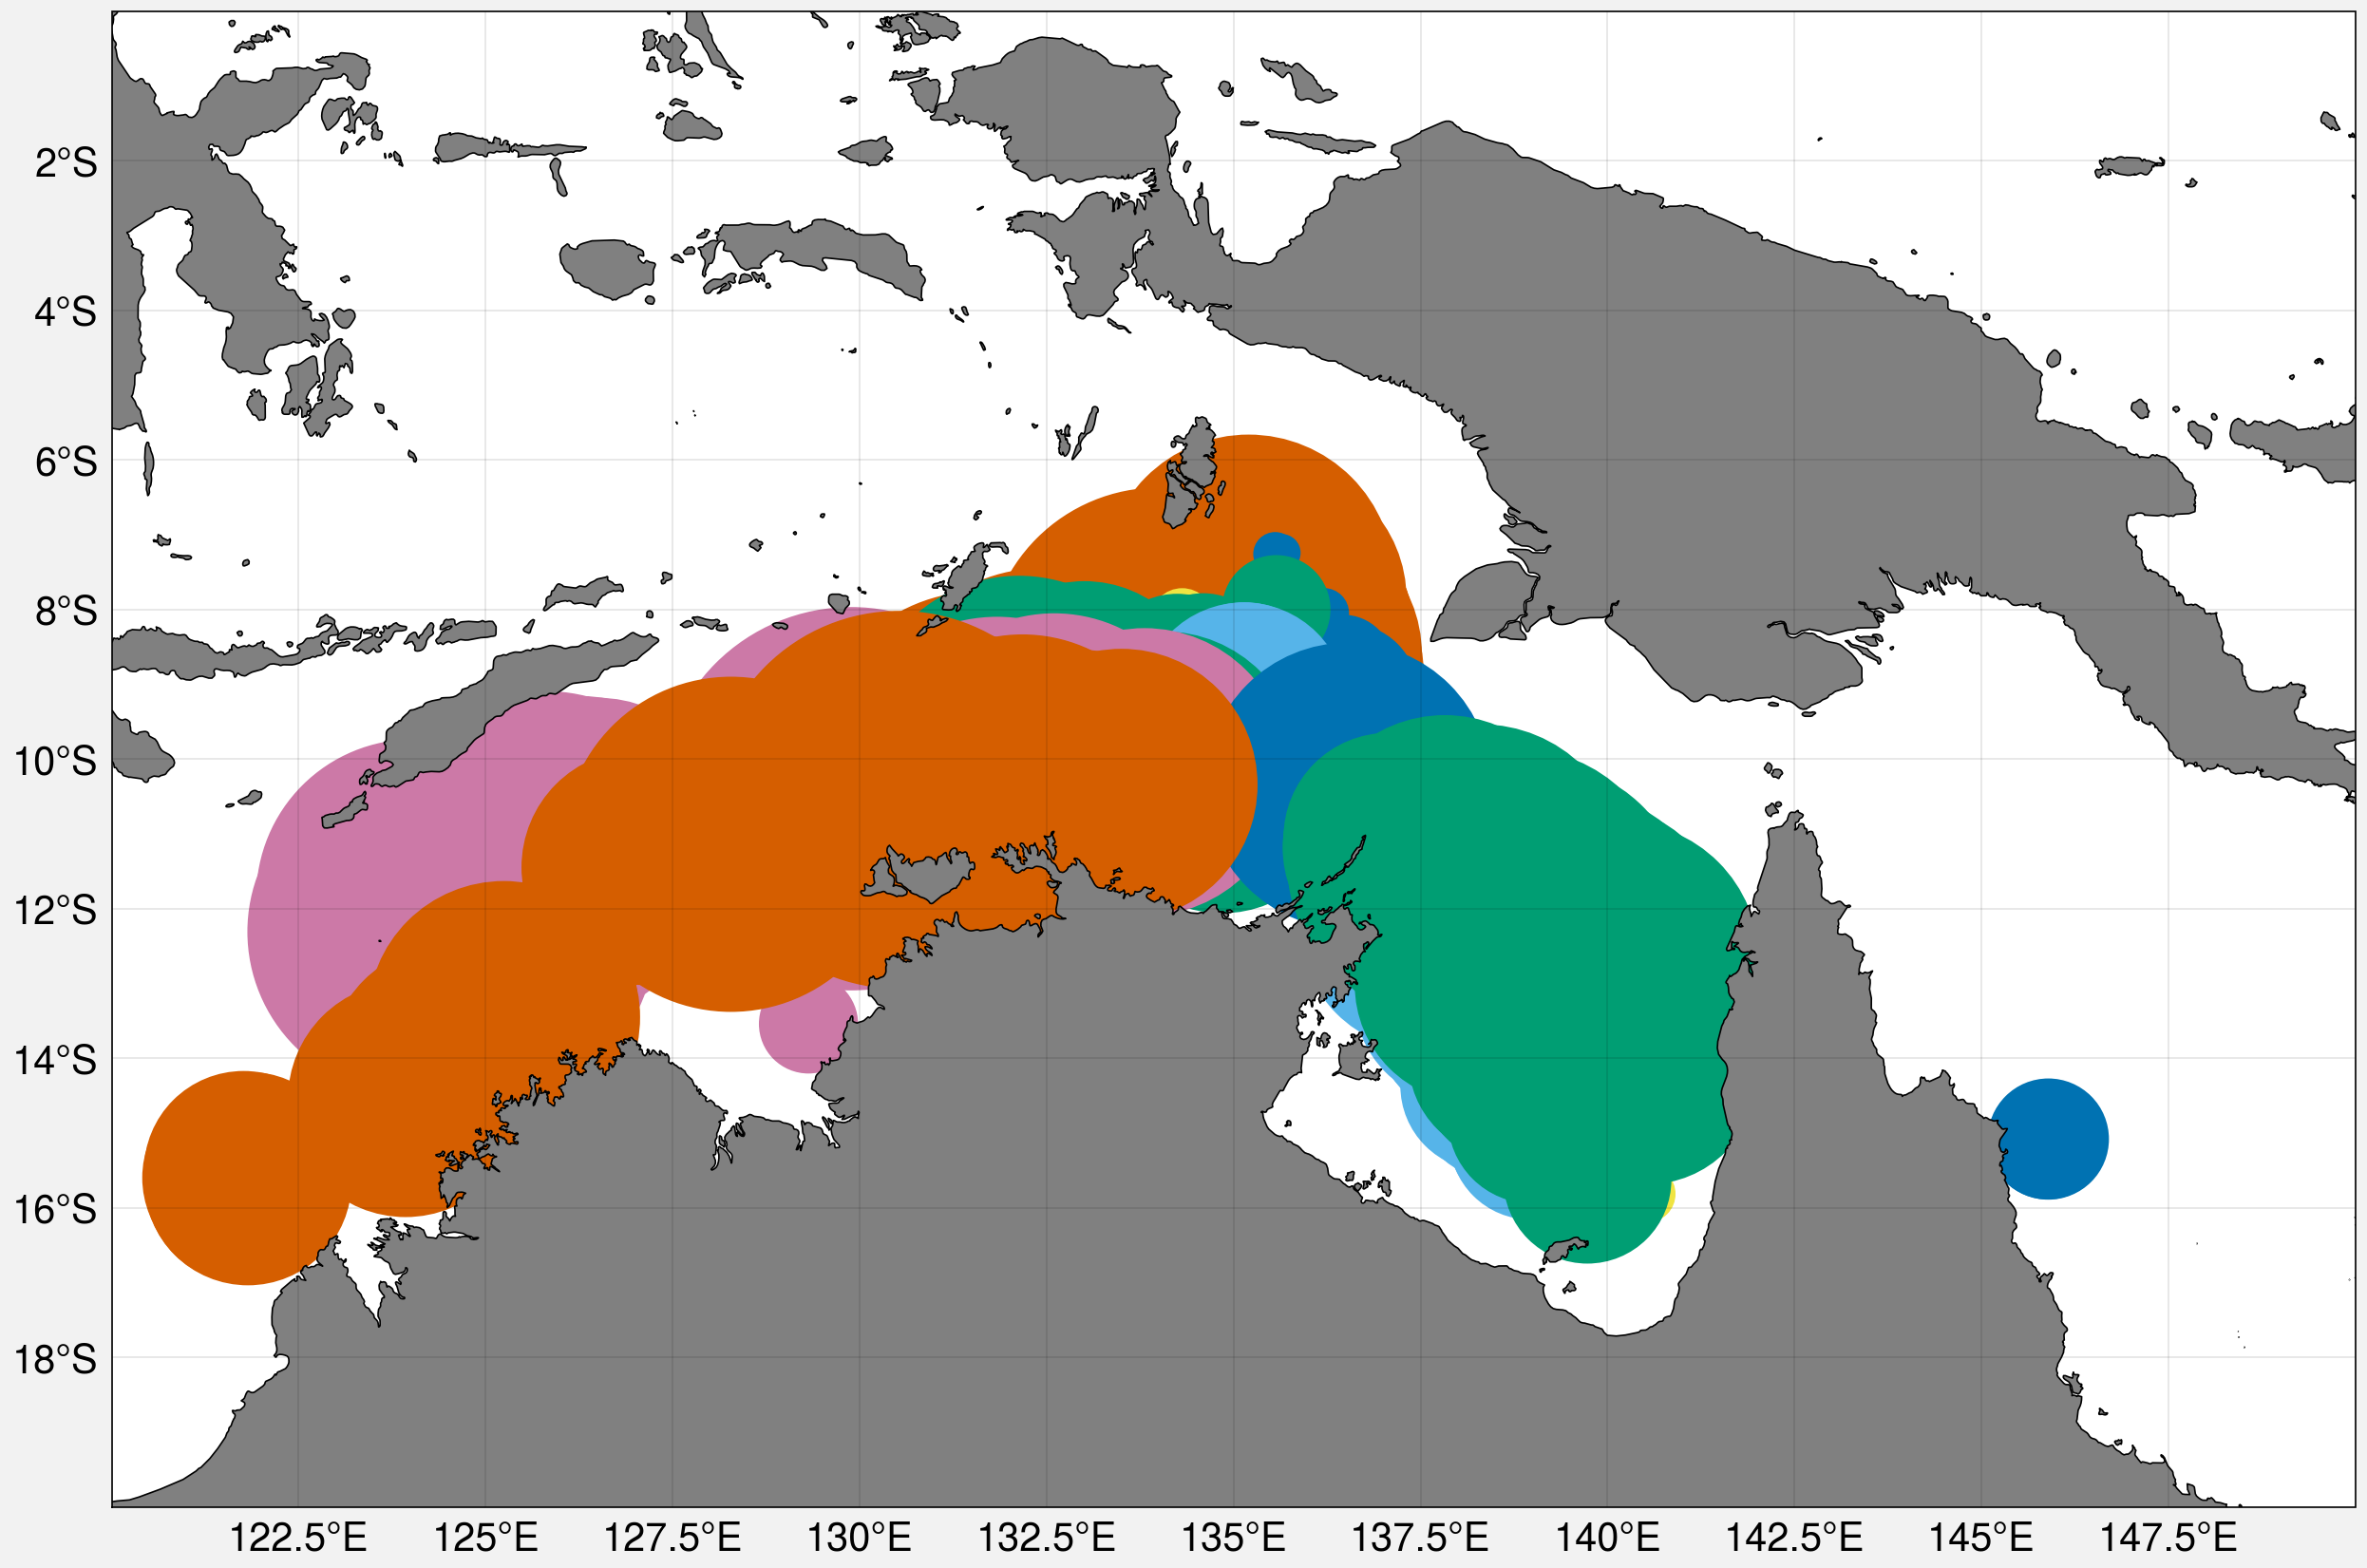

In [184]:
proplot.rc['land.color'] = 'grey'
proplot.rc['text.labelsize'] = 15
proplot.rc['text.titlesize'] = 25
proplot.rc['abc.size'] = 15
proplot.rc['abc.style'] = 'a'
proplot.rc.reso = 'hi'

#Northern Australia Domain
lon_min = 120
lon_max = 150
lat_min = -20
lat_max = 0

target_temperature = 27.0
ref_date = pandas.Timestamp('1950-01-01')


plt.figure(1,figsize=(20,10))
fig, axs = proplot.subplots(ncols=1,nrows=1,axwidth='30cm',proj={1:proj} ) #,2:None,3:None,4:None})
axs.format(abc=False,share=0,land=True) #, color='grey')

all_turtle_dates = []

for i_turtle in turtle_files:
    
    print('Computing TCHP on turtle: ', i_turtle)
    current_turtle = xarray.open_dataset(i_turtle,decode_times=False)
    
    TCHP = np.zeros(current_turtle['N_PROF'].size,dtype='float32')
    
    for i_profile in range(0,current_turtle['N_PROF'].size):
    
        depth_profile        = current_turtle['PRES_ADJUSTED'][i_profile,:]
        temperature_profile  = current_turtle['TEMP_ADJUSTED'][i_profile,:] #- target_temperature
        idx_depth = np.nonzero(temperature_profile.values<=target_temperature)[0]
        temperature_profile = temperature_profile.fillna(0)

    
    
    
    
        if len(idx_depth) == 0:
        #print('Blah!')
            TCHP[i_profile] = (temperature_profile-target_temperature).integrate(coord='N_LEVELS').values
        #dsada
        
        else:
            TCHP[i_profile] = ((temperature_profile.isel(N_LEVELS=slice(0,idx_depth[-1]))) -target_temperature).integrate(coord='N_LEVELS')
    
        turtle_dates = []
        for i_timestamp in current_turtle['JULD'].values:
            turtle_dates.append(np.datetime64(pandas.Timedelta(i_timestamp,'d') + ref_date))
        #print(turtle_dates)
    
    
    
    turtle_dates = np.asarray(turtle_dates)
    
    all_turtle_dates.append(turtle_dates)
    
    axs[0].scatter(current_turtle['LONGITUDE'],current_turtle['LATITUDE'], s=100*TCHP) #,c=turtle_dates)
    
    
axs[0].format(land=False,coast=True,facecolor='white',
                            lonlim=(lon_min, lon_max), latlim=(lat_min, lat_max), 
                            labels=True,lonlines=np.arange(0,360,2.5),latlines=np.arange(-80,50,2))

all_turtle_dates = np.concatenate(all_turtle_dates)
min_, max_ = all_turtle_dates.min(), all_turtle_dates.max()

#axs[0].clims(min_, max_)
#turtle_date = pandas.to_datetime(turtle_dataframe['date'].values)
#
#animal_colors = proplot.Colors('tab20')
#
#start_date = turtle_date.min()
#end_date   = turtle_date.max()


#date_range = pandas.date_range(start_date,end_date,freq='1H')
#
#unique_ids = turtle_dataframe['id'].unique()



#image_counter = 0
#for i_time in range(0,date_range.size-1):

(20, 30)

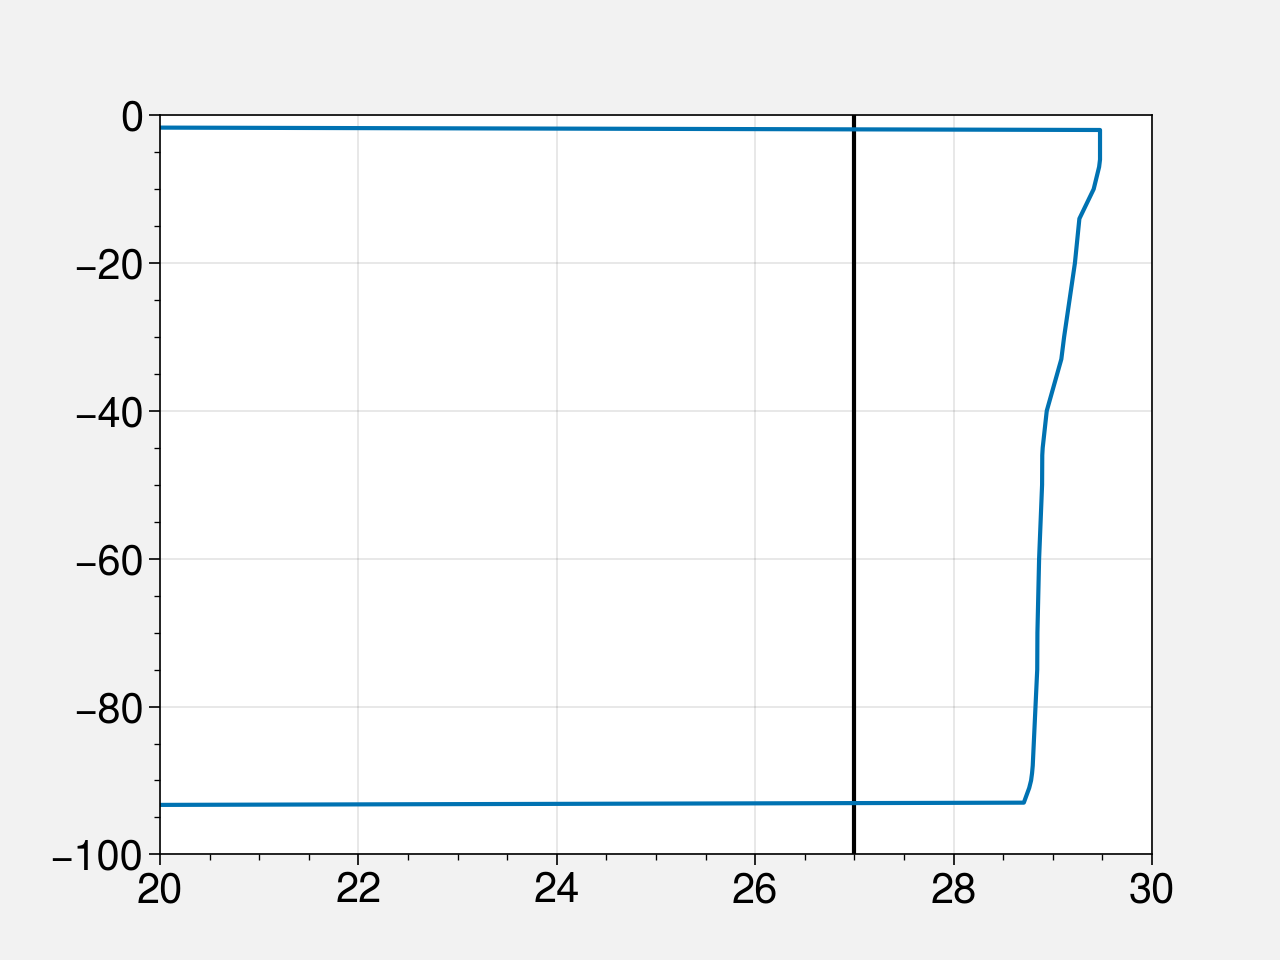

In [177]:
plt.plot(temperature_profile,-current_turtle['PRES_ADJUSTED'][0,:])
plt.vlines(27,ymin=-100,ymax=0)
plt.ylim([-100,0])
plt.xlim([20,30])

In [178]:
idx_depth

array([], dtype=int64)

In [142]:
turtle_dates.shape

(57,)

In [132]:
dates_to_get = ['2023-04-08','2023-04-10','2023-04-12','2023-04-14']

index_for_dates = []
for i_date in dates_to_get:
    idx = np.nonzero(pandas.to_datsingle_turtle['date'].values>=i_date)[0][0]
    index_for_dates.append(idx)
    
temperature_on_dates = single_turtle.isel(N_PROF=index_for_dates)

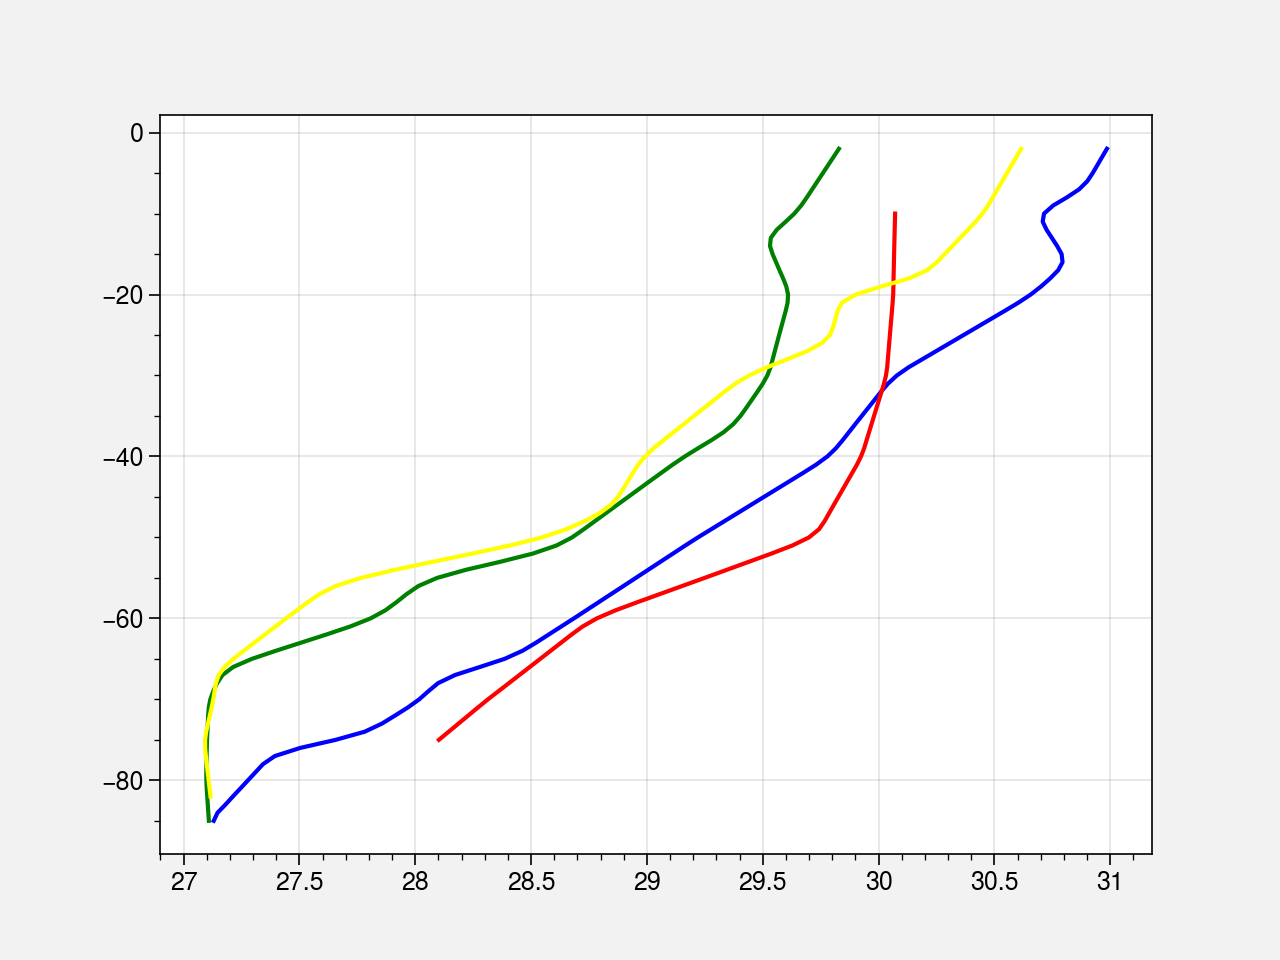

In [264]:
plt.plot(temperature_on_dates['TEMP_ADJUSTED'][0,:],-temperature_on_dates['PRES_ADJUSTED'][0,:],color='blue')
plt.plot(temperature_on_dates['TEMP_ADJUSTED'][1,:],-temperature_on_dates['PRES_ADJUSTED'][1,:],color='red')
plt.plot(temperature_on_dates['TEMP_ADJUSTED'][2,:],-temperature_on_dates['PRES_ADJUSTED'][2,:],color='green')
plt.plot(temperature_on_dates['TEMP_ADJUSTED'][3,:],-temperature_on_dates['PRES_ADJUSTED'][3,:],color='yellow')


#plt.plot(temperature_on_dates['N_squared'][0,:],-temperature_on_dates['PRES_ADJUSTED'][0,0:-1],color='blue')
#plt.plot(temperature_on_dates['N_squared'][1,:],-temperature_on_dates['PRES_ADJUSTED'][1,0:-1],color='red')
#plt.plot(temperature_on_dates['N_squared'][2,:],-temperature_on_dates['PRES_ADJUSTED'][2,0:-1],color='green')
#plt.plot(temperature_on_dates['N_squared'][3,:],-temperature_on_dates['PRES_ADJUSTED'][3,0:-1],color='yellow')






In [172]:
index_for_dates

[524, 529, 533, 541]